In [15]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [16]:
with open('../eeg/digit/data.pkl', 'rb') as f:
	data = pickle.load(f, encoding='latin1')

In [17]:
x_test = data['x_test']
y_test = data['y_test']

In [18]:
class EEGDataset(torch.utils.data.Dataset):
	def __init__(self, data, labels):
		self.data = data
		self.labels = labels
	
	def __len__(self):
		return len(self.data)
	
	def __getitem__(self, idx):
		return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [19]:
class CNNModel(nn.Module):
	def __init__(self, channels, observations, num_classes):
		super(CNNModel, self).__init__()
		self.bn1 = nn.BatchNorm2d(channels)
		self.conv1 = nn.Conv2d(1, observations, kernel_size=(1, 4))
		self.relu1 = nn.ReLU()
		self.conv2 = nn.Conv2d(observations, 25, kernel_size=(channels, 1))
		self.relu2 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(1, 3))
		self.conv3 = nn.Conv2d(1, 50, kernel_size=(4, 25))
		self.relu3 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(1, 3))
		self.conv4 = nn.Conv2d(1, 100, kernel_size=(50, 2))
		self.flatten = nn.Flatten()
		self.bn2 = nn.BatchNorm1d(100)
		self.fc1 = nn.Linear(100, 100)
		self.bn3 = nn.BatchNorm1d(100)
		self.fc2 = nn.Linear(100, num_classes)

	def forward(self, x):
		x = self.bn1(x)
		x = x.permute(0, 3, 1, 2)
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool1(x)
		x = x.permute(0, 2, 3, 1)
		x = self.conv3(x)
		x = self.relu3(x)
		x = x.permute(0, 3, 1, 2)
		x = self.maxpool2(x)
		x = self.conv4(x)
		x = self.flatten(x)
		x = self.bn2(x)
		x = self.fc1(x)
		x = self.bn3(x)
		x = self.fc2(x)
		return x

In [20]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.bn1 = nn.BatchNorm2d(14)
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        """
        Shape of x: (N, T, C) 
        N: batch_size, T: seq_len(time), C: input_size(features/channels)
        """
        x = self.bn1(x)
        x = x.squeeze()
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        logits = self.fc(lstm_out[:, -1, :])
        return logits

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
test_loader = DataLoader(EEGDataset(x_test, y_test), batch_size=64, shuffle=False)

In [23]:
model1 = CNNModel(channels=14, observations=32, num_classes=10).to(device)
model1.load_state_dict(torch.load('eeg_cnn.pth'))
model1.eval()

CNNModel(
  (bn1): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(1, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 25, kernel_size=(14, 1), stride=(1, 1))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(1, 50, kernel_size=(4, 25), stride=(1, 1))
  (relu3): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(1, 100, kernel_size=(50, 2), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [24]:
model2 = LSTM(num_classes=10, input_size=32, hidden_size=128, num_layers=2).to(device)
model2.load_state_dict(torch.load('eeg_lstm.pth'))
model2.eval()

LSTM(
  (bn1): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(32, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [25]:
def evaluate(model, loader, criterion):
	model.eval()
	losses = []
	preds = []
	targets = []
	with torch.no_grad():
		for x, y in loader:
			x, y = x.to(device), y.to(device)
			output = model(x)
			loss = criterion(output, y)
			losses.append(loss.item())
			preds.append(output.argmax(dim=1).cpu().numpy())
			targets.append(torch.argmax(y, dim=1).cpu().numpy())
	
	losses = np.mean(losses)
	preds = np.concatenate(preds)
	targets = np.concatenate(targets)
	accuracy = accuracy_score(targets, preds)
	cm = confusion_matrix(targets, preds)
	report = classification_report(targets, preds)
	f1 = f1_score(targets, preds, average='macro')
	return losses, accuracy, cm, report, f1

In [26]:
criterion = nn.CrossEntropyLoss()
loss, accuracy, cm1, report, f1 = evaluate(model1, test_loader, criterion)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}')
print(cm1)
print(report)

Loss: 1.9848, Accuracy: 0.7093, F1: 0.7049
[[445  24   3  13  20  16   8   1   9   8]
 [ 16 444   2  20  43   8   2   1   6  17]
 [ 24  61 262  57  31  42   9  17  33  19]
 [ 15  35   2 440  16  13   7   5  15  11]
 [  8  17   3  24 485  14   3   3  11   7]
 [  7  21   4   7  32 459   7  11   6   9]
 [  6  26  18  48  49  39 288  20  56  21]
 [ 21  37  13  15  29  31   2 365  49  13]
 [  5  27  17  26  25   5  15  13 430  24]
 [  9  19  14   6  16  26  25  11  41 384]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       547
           1       0.62      0.79      0.70       559
           2       0.78      0.47      0.59       555
           3       0.67      0.79      0.72       559
           4       0.65      0.84      0.73       575
           5       0.70      0.82      0.75       563
           6       0.79      0.50      0.61       571
           7       0.82      0.63      0.71       575
           8       0.66      0.73      

In [27]:
loss, accuracy, cm2, report, f1 = evaluate(model2, test_loader, criterion)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}')
print(cm2)
print(report)

Loss: 1.5110, Accuracy: 0.7354, F1: 0.7322
[[452   8   8  14  11  15  11  10  13   5]
 [ 19 437   2  24  13  16   0   0  12  36]
 [ 15  46 296  43  36  22  31  22  22  22]
 [ 19  31   4 421  20  15   8   7  22  12]
 [  4  13   1  24 490  15   9   3  10   6]
 [  5  17   0   5  23 455  17  10  19  12]
 [ 20  22  28  30  20  51 318   8  55  19]
 [  8  40   5  21  25  21  12 388  42  13]
 [  5  25   1  10   8  10   5   7 476  40]
 [  8   4  14   9  15  31   7  17  30 416]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       547
           1       0.68      0.78      0.73       559
           2       0.82      0.53      0.65       555
           3       0.70      0.75      0.73       559
           4       0.74      0.85      0.79       575
           5       0.70      0.81      0.75       563
           6       0.76      0.56      0.64       571
           7       0.82      0.67      0.74       575
           8       0.68      0.81      

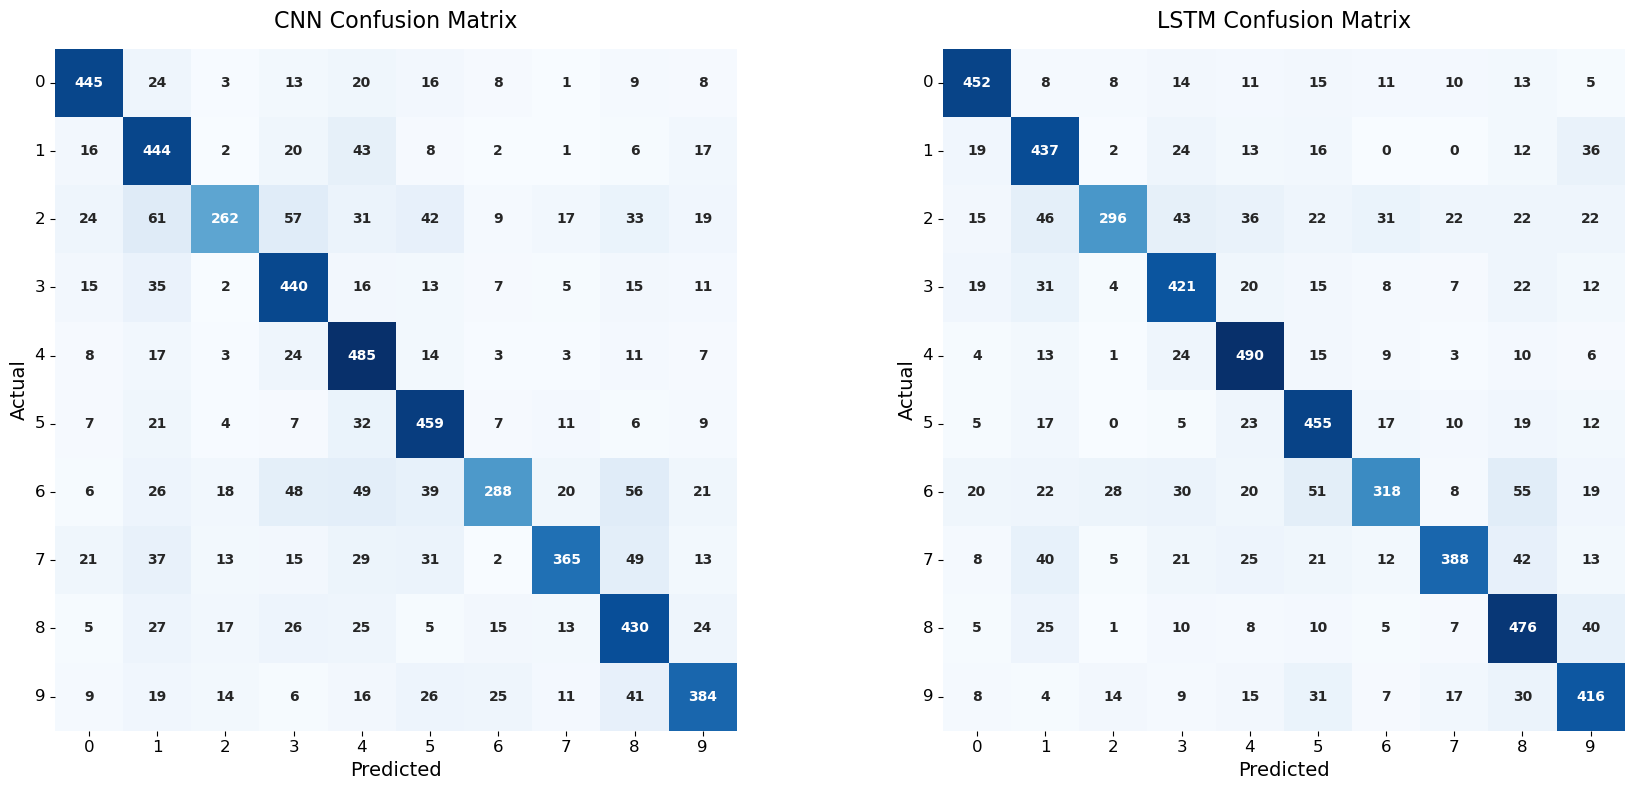

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

classes = [str(i) for i in range(10)]

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# CNN Confusion Matrix
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', square=True, ax=ax[0],
            cbar=False, annot_kws={"size": 10, "weight": "bold"})
ax[0].set_title('CNN Confusion Matrix', fontsize=16, pad=15)
ax[0].set_xlabel('Predicted', fontsize=14)
ax[0].set_ylabel('Actual', fontsize=14)
ax[0].set_xticklabels(classes, rotation=0, fontsize=12)
ax[0].set_yticklabels(classes, rotation=0, fontsize=12)

# LSTM Confusion Matrix
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', square=True, ax=ax[1],
            cbar=False, annot_kws={"size": 10, "weight": "bold"})
ax[1].set_title('LSTM Confusion Matrix', fontsize=16, pad=15)
ax[1].set_xlabel('Predicted', fontsize=14)
ax[1].set_ylabel('Actual', fontsize=14)
ax[1].set_xticklabels(classes, rotation=0, fontsize=12)
ax[1].set_yticklabels(classes, rotation=0, fontsize=12)

fig.tight_layout()
plt.show()
